In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import numpy as np
import cv2

import os
import cv2
import numpy as np

folder_path = '/content/drive/MyDrive/Image_denoising/Train/high'

# List to store the image arrays
image_arrays = []

# Get a sorted list of all image files in the folder
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')])

# Loop through the sorted list of image files
for filename in image_files:

    image = cv2.imread(os.path.join(folder_path, filename))
    image_arrays.append(image)

# Convert the list of arrays to a single numpy array
image_arrays_np = np.array(image_arrays)

# Check the shape of the numpy array
print(image_arrays_np.shape)

(485, 400, 600, 3)


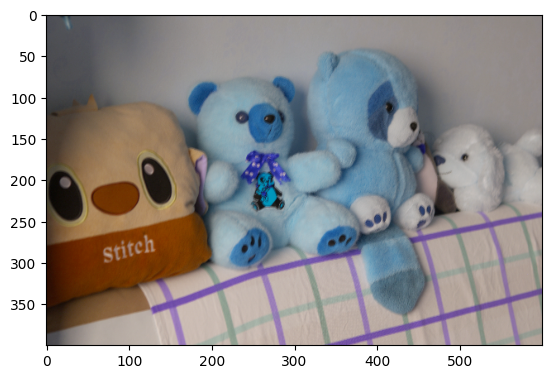

In [42]:
plt.imshow(image_arrays_np[0])

In [38]:
#Checking shapes of all images

shapes = [img.shape for img in image_arrays]
unique_shapes = set(shapes)
print("Unique shapes of images:", unique_shapes)
if len(unique_shapes) == 1:
    image_arrays_np = np.array(image_arrays)
    print("Shape of the array:", image_arrays_np.shape)
else:
    print("Images have different shapes. Please resize or no")

Unique shapes of images: {(400, 600, 3)}
Shape of the array: (485, 400, 600, 3)


In [43]:

folder_path_2 = '/content/drive/MyDrive/Image_denoising/Train/low'

# List to store the image arrays
noised_image = []
image_files_2 = sorted([f for f in os.listdir(folder_path_2) if f.endswith('.jpg') or f.endswith('.png')])
# Loop through all the image files in the folder
for filename in image_files_2:
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Add more extensions if needed
        image = cv2.imread(os.path.join(folder_path_2, filename))
        noised_image.append(image)

# Convert the list of arrays to a single numpy array
noised_arrays_np = np.array(noised_image)

# Check the shape of the numpy array
print("Shape of the array:", noised_arrays_np.shape)


Shape of the array: (485, 400, 600, 3)


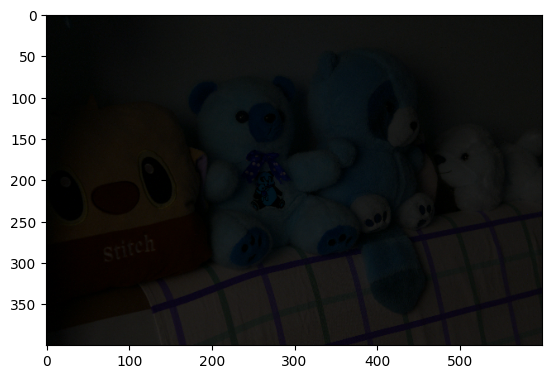

In [44]:
plt.imshow(noised_arrays_np[0])

In [45]:
import cv2
# Define the new size
new_size = (200, 300)  # (width, height)

def resize_images(images, size):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, size)
        resized_images.append(resized_image)
    return np.array(resized_images)

# Assuming noised_arrays_np and image_arrays_np are already defined as arrays of images
print("Original size of noised images:", noised_arrays_np.shape)
print("Original size of clean images:", image_arrays_np.shape)

# Resize the images
noised_arrays_np_resized = resize_images(noised_arrays_np, new_size)
image_arrays_np_resized = resize_images(image_arrays_np, new_size)

print("Resized size of noised images:", noised_arrays_np_resized.shape)
print("Resized size of clean images:", image_arrays_np_resized.shape)

Original size of noised images: (485, 400, 600, 3)
Original size of clean images: (485, 400, 600, 3)
Resized size of noised images: (485, 300, 200, 3)
Resized size of clean images: (485, 300, 200, 3)


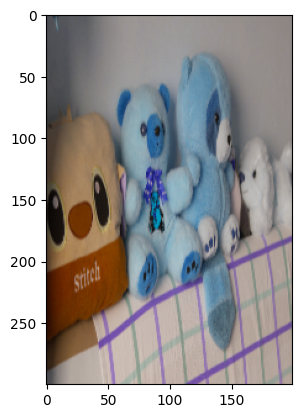

In [46]:
import matplotlib.pyplot as plt
plt.imshow(image_arrays_np_resized[0])

In [8]:
image_arrays_np_resized[0]

array([[[0.45882353, 0.45490196, 0.46535948],
        [0.46928105, 0.4620915 , 0.47908497],
        [0.4640523 , 0.4627451 , 0.4764706 ],
        ...,
        [0.22875817, 0.2647059 , 0.3019608 ],
        [0.21568628, 0.25816995, 0.29281047],
        [0.12352941, 0.16078432, 0.18039216]],

       [[0.45882353, 0.45294118, 0.4764706 ],
        [0.46666667, 0.46078432, 0.48039216],
        [0.47254902, 0.4627451 , 0.4862745 ],
        ...,
        [0.23333333, 0.26862746, 0.29803923],
        [0.21568628, 0.25686276, 0.2882353 ],
        [0.12352942, 0.16078432, 0.18431373]],

       [[0.45882353, 0.4509804 , 0.47124183],
        [0.4738562 , 0.4627451 , 0.48169935],
        [0.4745098 , 0.47254902, 0.4862745 ],
        ...,
        [0.23137255, 0.2627451 , 0.29411766],
        [0.2254902 , 0.25882354, 0.2901961 ],
        [0.11372549, 0.15424837, 0.17843138]],

       ...,

       [[0.16013072, 0.1640523 , 0.19542484],
        [0.21960784, 0.22941177, 0.24313726],
        [0.31633988, 0

In [47]:

train_ratio = 0.8
train_size = int(train_ratio * noised_arrays_np_resized.shape[0])

train_noisy, test_noisy = noised_arrays_np_resized[:train_size], noised_arrays_np_resized[train_size:]
train_clean, test_clean = image_arrays_np_resized[:train_size], image_arrays_np_resized[train_size:]

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pytorch_msssim
import numpy as np

# Define a custom dataset with augmentation
class AugmentedDataset(Dataset):
    def __init__(self, noisy_images, clean_images, transform=None):
        self.noisy_images = noisy_images
        self.clean_images = clean_images
        self.transform = transform

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        noisy_img = self.noisy_images[idx]
        clean_img = self.clean_images[idx]

        if self.transform:
            seed = np.random.randint(2147483647)  # Make a seed with numpy generator
            torch.manual_seed(seed)  # Apply this seed to transforms
            noisy_img = self.transform(noisy_img)
            torch.manual_seed(seed)
            clean_img = self.transform(clean_img)

        return noisy_img, clean_img

# Define the Zero-DCE network for image denoising
class ZeroDCE(nn.Module):
    def __init__(self):
        super(ZeroDCE, self).__init__()
        self.relu = nn.ReLU(inplace=True)

        self.e_conv1 = nn.Conv2d(3, 16, 3, 1, 1, bias=True)  # Reduced number of filters
        self.e_conv2 = nn.Conv2d(16, 16, 3, 1, 1, bias=True)
        self.e_conv3 = nn.Conv2d(16, 16, 3, 1, 1, bias=True)
        self.e_conv4 = nn.Conv2d(16, 16, 3, 1, 1, bias=True)
        self.e_conv5 = nn.Conv2d(16, 16, 3, 1, 1, bias=True)
        self.e_conv6 = nn.Conv2d(16, 16, 3, 1, 1, bias=True)
        self.e_conv7 = nn.Conv2d(16, 3, 3, 1, 1, bias=True)  # Ensure the output has 3 channels

    def forward(self, x):
        x1 = self.relu(self.e_conv1(x))
        x2 = self.relu(self.e_conv2(x1))
        x3 = self.relu(self.e_conv3(x2))
        x4 = self.relu(self.e_conv4(x3))
        x5 = self.relu(self.e_conv5(x4))
        x6 = self.relu(self.e_conv6(x5))
        x_r = torch.tanh(self.e_conv7(x6))

        x = x + x_r
        return x

# Define the loss functions
mse_criterion = nn.MSELoss()
ssim_criterion = pytorch_msssim.MS_SSIM(data_range=1.0, win_size=7)

# Mixed loss function
def mixed_loss(denoised, clean):
    mse_loss = mse_criterion(denoised, clean)
    ssim_loss = 1 - ssim_criterion(denoised, clean)
    return mse_loss + 0.1 * ssim_loss

# Load your dataset (image_arrays_np_resized and noised_arrays_np_resized are numpy arrays of images)
min_size = min(train_clean.shape[0], train_noisy.shape[0])
high_images_resized = train_clean[:min_size]
low_images_resized =train_noisy[:min_size]

assert high_images_resized.size != 0, "High-quality images were not loaded properly."
assert low_images_resized.size != 0, "Low-quality images were not loaded properly."

# Check if images are loaded and have the same shape
assert high_images_resized.shape == low_images_resized.shape, "The arrays have different dimensions. Please check your image resizing."

# Normalize the images to [0, 1]
high_images_resized = high_images_resized / 255.0
low_images_resized = low_images_resized / 255.0

# Transpose the arrays to match PyTorch's channel-first format
noisy_images = low_images_resized.transpose(0, 3, 1, 2)
clean_images = high_images_resized.transpose(0, 3, 1, 2)

# Convert to tensors
noisy_tensor = torch.from_numpy(noisy_images).float()
clean_tensor = torch.from_numpy(clean_images).float()

# Define augmentation with smaller crop size
augmentation = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop(128, padding=4)  # Ensure the crop size is appropriate for MS-SSIM
])

# Create augmented dataset and dataloader
augmented_dataset = AugmentedDataset(noisy_tensor, clean_tensor, transform=augmentation)
dataloader = DataLoader(augmented_dataset, batch_size=8, shuffle=True, num_workers=4)  # Reduced batch size and added num_workers

# Initialize the model, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ZeroDCE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


# Train the model
for epoch in range(10):
    model.train()
    epoch_loss = 0
    for batch in dataloader:
        noisy, clean = batch
        noisy, clean = noisy.to(device), clean.to(device)
        optimizer.zero_grad()
        denoised = model(noisy)
        loss = mixed_loss(denoised, clean)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    scheduler.step()
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(dataloader):.4f}')

# Evaluate the model
model.eval()
psnr_values = []
with torch.no_grad():
    for batch in dataloader:
        noisy, clean = batch
        noisy, clean = noisy.to(device), clean.to(device)
        denoised = model(noisy)
        psnr = 10 * torch.log10(1 / mse_criterion(denoised, clean))
        psnr_values.append(psnr.item())
print(f'Average PSNR: {np.mean(psnr_values):.4f}')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1, Loss: 0.1140
Epoch 2, Loss: 0.0584
Epoch 3, Loss: 0.0521
Epoch 4, Loss: 0.0465
Epoch 5, Loss: 0.0475
Epoch 6, Loss: 0.0458
Epoch 7, Loss: 0.0452
Epoch 8, Loss: 0.0413
Epoch 9, Loss: 0.0423
Epoch 10, Loss: 0.0423
Average PSNR: 15.7818
